##<b><u>Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

##**Importing Libraries**

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# loading csv file in tweet_data dataframe
tweet_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/sentiment analysis/Coronavirus Tweets.csv',encoding='latin')

## **Exploratory Data Analysis**

In [ ]:
#how many rows and columns in dataset
tweet_data.shape

(41157, 6)

in this dataset total 6 columns and 41157 rows(data points) are present 

In [ ]:
# details information about dataset
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
#first 10 datapoints of dataset.
tweet_data.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and ot...",Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,"Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16. We will continue to process online a...",Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our h...",Negative


In [ ]:
# Unique numbers of every column datapoints
tweet_data.nunique()

UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

###**Details Features information**

* **UserName**: This is the username(encoded in number) unique for every datapoints
* **ScreenName**: This is the ScreenName(encoded in number) unique for every datapoints
* **Location**: places wherefrom tweets are comming
* **TweetAt**: date of tweets data collected
* **OriginalTweet**: Original tweets are stored (This feature is more important in our analysis)
* **Sentiment**: types of sentiment (Positive, Negative, Neutral, Extremely Positive, Extremely Negative) it is dependent variable.


 UserName and ScreenName features are not useful in our analysis, let's drop them

In [3]:
#dropping UserName and ScreenName features
tweet_data = tweet_data.drop(['UserName', 'ScreenName'], axis=1)

In [ ]:
#checking duplicate rows 
tweet_data.duplicated().sum()

0

no duplicate rows in dataset

In [ ]:
#checking null value in dataset
tweet_data.isnull().sum()

Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
#calculating null value percentage in location feature
tweet_data['Location'].isna().sum()/len(tweet_data) *100

20.87129771363316

* in Location feature have 8590 null value present that is 20.8% But this feature is not important for our sentiment analysis. Hence we will neglect these null values and no nead to treat null value for our analysis

##**Exploring All Features**

In [ ]:
#checking unique value feature-wise
tweet_data.nunique()

Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

*  ### **Location**

In [8]:
#top 10 location wise tweets
top_10_loc = tweet_data['Location'].value_counts().head(10)
top_10_loc_df = pd.DataFrame(top_10_loc)
top_10_loc_df.reset_index(inplace=True)
top_10_loc_df = top_10_loc_df.rename(columns={'index':'Location', 'Location':'Tweet_count'})
top_10_loc_df

,Location,Tweet_count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


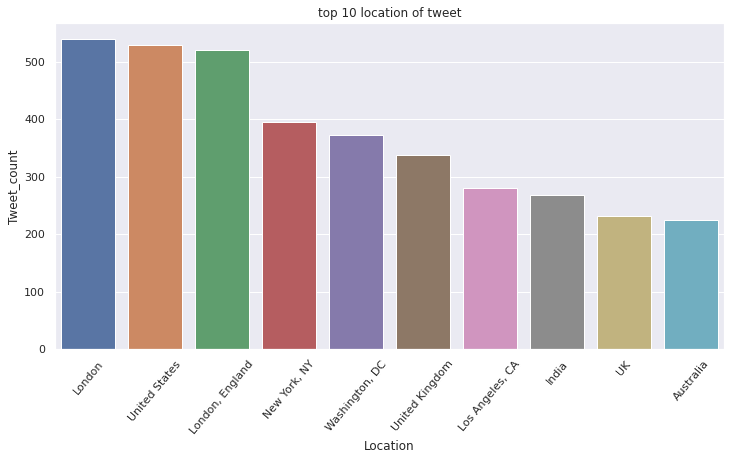

In [9]:
#visualize top 10 location wise tweets
plt.subplots(figsize=(12,6))
plt.title('top 10 location of tweet')
sns.barplot('Location','Tweet_count',data = top_10_loc_df)
plt.xticks(rotation = 50)
plt.show()

* most of the tweets comes from London and US

*  ### **TweetAt**

In [ ]:
#checking unique value in TweetAt feature
tweet_data['TweetAt'].value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

* all tweets belongs to March and April months of 2020

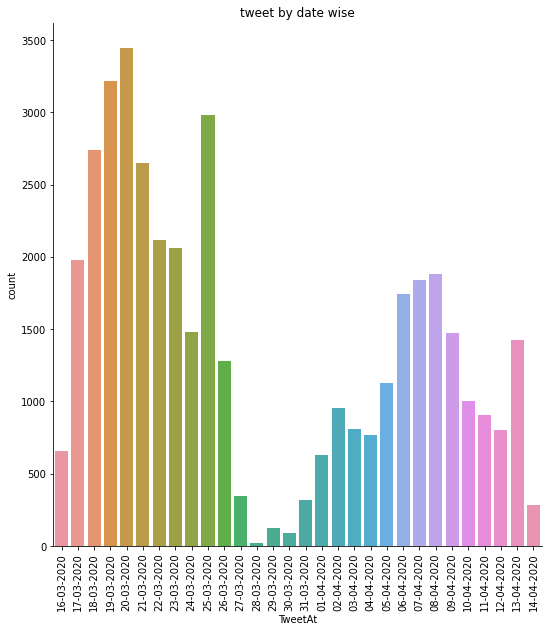

In [6]:
#visualize tweet by date wise
sns.catplot('TweetAt',kind = 'count',height=8,data = tweet_data)
plt.xticks(rotation = 90)
plt.title('tweet by date wise')
plt.show()

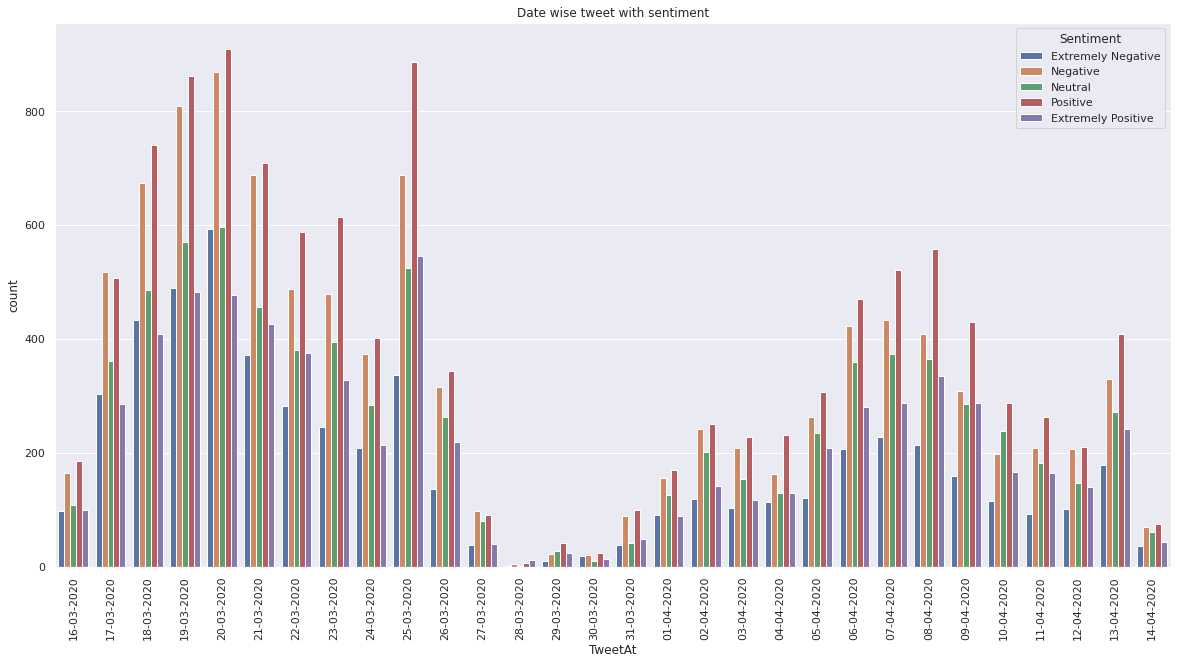

In [7]:
#visualize tweet by date wise with Sentiment
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot('TweetAt',hue='Sentiment',data = tweet_data, hue_order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.title('Date wise tweet with sentiment')
plt.xticks(rotation = 90)
plt.show()


*  ### **Sentiment**

* this feature is our target feature in our analysis

In [4]:
#checking unique value in Sentiment feature
tweet_data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

* there are five types of Sentiment in this Dataset: 
  Positive,  Negative, Neutral, Extremely Positive, Extremely Negative

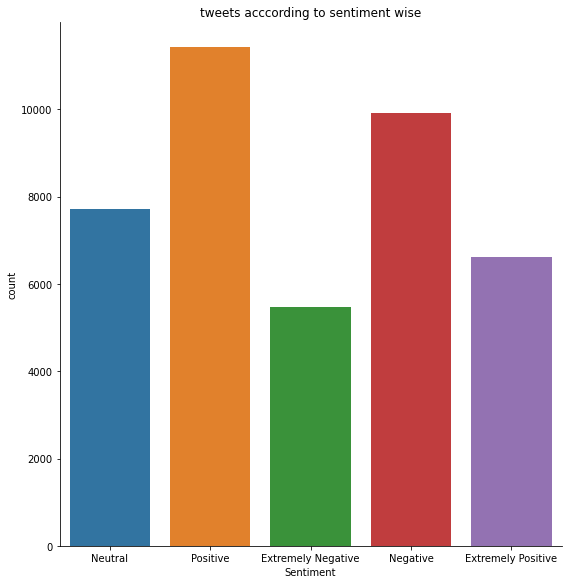

In [5]:
# tweets acccording to sentiment wise
sns.catplot("Sentiment", kind="count", height=8, data=tweet_data)
plt.title("tweets acccording to sentiment wise")
plt.show()

*   ### **Exploring Sentiment type-wise**

In [ ]:
#extracting Extremely Negative tweets
tweet_data[tweet_data['Sentiment']=='Extremely Negative']

,Location,TweetAt,OriginalTweet,Sentiment
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative
20,southampton soxx xxx,16-03-2020,with 100 nations inficted with covid 19 the world must not play fair with china 100 goverments must demand china adopts new guilde lines on food safty the chinese goverment is guilty...,Extremely Negative
27,Everywhere You Are!,16-03-2020,"This morning I tested positive for Covid 19. I feel ok, I have no symptoms so far but have been isolated since I found out about my possible exposure to the virus. Stay home people and be pragmat...",Extremely Negative
29,"Someplace, USA",16-03-2020,@7SealsOfTheEnd Soon with dwindling supplies unlawful Panicky people will be breaking into Closed Stores &amp; Supermarkets to Raid them as they normally do during a Crisis so massive as the #Coro...,Extremely Negative
42,Houston,16-03-2020,CHECK VIDEO ?? https://t.co/1ksn9Brl02 ??No food ? in USA market due to coronavirus panic we gonna die from starvation #CoronavirusOutbreak #coronavirus #houston #nofood #Notoiletpaper #NoHandShak...,Extremely Negative
...,...,...,...,...
41115,NaN,14-04-2020,"Food Banks are not equipped for a 30% unemployment rate. The federal government must provide direct aid to everyone, very quickly.\r\r\n\r\r\n""The Coronavirus Food Bank Crisis Is Already Underway""...",Extremely Negative
41128,"Melbourne, Australia",14-04-2020,"The COVID-19 pandemic and global oil price wars are having an economic impact worldwide, but one consequence is lower fuel prices at Australian petrol pumps for the foreseeable.\r\r\n\r\r\n#UniMel...",Extremely Negative
41130,NaN,14-04-2020,Squeo works in the meat department of a Kroger supermarket in Michigan. He knows of several grocery workers whoÂve tested positive for COVID-19 and one in his area who died. He worries that the b...,Extremely Negative
41133,Austria,14-04-2020,A Singaporean politician who slammed a woman snapped with seven supermarket trolleys during COVID-19 lockdown has been forced to eat humble pie after it turned out she was donating goods to the po...,Extremely Negative


In [ ]:
#details comment of Extremely Negative Tweet
tweet_data[tweet_data['Sentiment']=='Extremely Negative'].loc[41133,'OriginalTweet']

'A Singaporean politician who slammed a woman snapped with seven supermarket trolleys during COVID-19 lockdown has been forced to eat humble pie after it turned out she was donating goods to the poor\r\r\nhttps://t.co/EDBXXtdHxl\r\r\n#covid19 #lockdown'

In [ ]:
#extracting Negative tweets
tweet_data[tweet_data['Sentiment']=='Negative']

,Location,TweetAt,OriginalTweet,Sentiment
9,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our h...",Negative
24,Downstage centre,16-03-2020,@10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checko...,Negative
26,"Ketchum, Idaho",16-03-2020,"In preparation for higher demand and a potential food shortage, The Hunger Coalition purchased 10 percent more food and implemented new protocols due to the COVID-19 coronavirus. https://t.co/5Cec...",Negative
28,"New York, NY",16-03-2020,Do you see malicious price increases in NYC? The NYC Department of Consumer and Worker Protection (DCWP) has set up a page to digitally file a complaint. Click here: https://t.co/oEx6Y8mm2K\r\r\n\...,Negative
30,NaN,16-03-2020,There Is of in the Country The more empty shelves people see the more buying ensues the more food is out of stock,Negative
...,...,...,...,...
41127,NaN,14-04-2020,Today at the grocery store I saw someone getting a case of #Corona beer and I was about to jokingly say 'hey man i see you got Corona' then I stopped myself doing that thinking it would be the new...,Negative
41131,"Accra, Ghana",14-04-2020,"In every human affliction there are gainers and losers. In this case of Covid 19, the TELECOS are gaining beyond expectations. The level of internet being used at this moment is mind blowing. Gov...",Negative
41147,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?? #COVID19 #coronavirus #toiletpaper,Negative
41149,"Toronto, Ontario",14-04-2020,"Still shocked by the number of #Toronto supermarket employees working without some sort of mask. We all know by now, employees can be asymptomatic while spreading #coronavirus .",Negative


In [ ]:
#details comment of Negative Tweet
tweet_data[tweet_data['Sentiment']=='Negative'].loc[28,'OriginalTweet']

'Do you see malicious price increases in NYC? The NYC Department of Consumer and Worker Protection (DCWP) has set up a page to digitally file a complaint. Click here: https://t.co/oEx6Y8mm2K\r\r\n\r\r\nTo file a complaint (use the word"Overcharge") https://t.co/MdMmoBttOP\r\r\n#COVID19 #CovidNYC'

In [ ]:
#extracting Neutral tweets
tweet_data[tweet_data['Sentiment']=='Neutral']

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
7,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
10,"Makati, Manila",16-03-2020,"All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a singl...",Neutral
16,Saudi Arabia,16-03-2020,????? ????? ????? ????? ??\r\r\n?????? ????? ??????? ????????? ?\r\r\n#????_???? ????? ???? ?????? ? #????????? ?????? ?? 13 ???? ?? ?? ???? ?????? ?? ??\r\r\n#???_???????? ????? ??? ???? ? https:...,Neutral
17,"Ontario, Canada",16-03-2020,"@eyeonthearctic 16MAR20 Russia consumer surveillance watchdog reported case in high Arctic where a man who traveled to Iran has COVID-19 and 101 are ""observed""\r\r\nhttps://t.co/4WnrrK9oKC https:/...",Neutral
...,...,...,...,...
41141,India,14-04-2020,#Coronavirus ?? ????? ??? ????? ?? ??? ??????? ?? ????? ???? ?? ?? ??? ??? ?? ??? ?? ??????? ???? ??? ???????????? @narendramodi ?? ??? ????? ?? ????? ???? ?? ????\r\r\n#ATCard #StayHome #Lockdown...,Neutral
41143,In burning hell.,14-04-2020,https://t.co/8s4vKvcO1r #5gtowers?? #EcuadorUnido #cruiseships #SaveTheChildren #wuhan #BillGates?#SocialDistance #coronavirus is caused by #cellpoisoning from #radiation #cancer #exosomes #youcan...,Neutral
41144,NaN,14-04-2020,@_Sunrise_SV @Gamzap @NPR What does not having a supermarket nearby have to do with getting COVID-19?,Neutral
41152,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket shelves in #NZ lockdown #COVID-19 https://t.co/cz89uA0HNp,Neutral


In [ ]:
#details comment of Neutral Tweet
tweet_data[tweet_data['Sentiment']=='Neutral'].loc[10,'OriginalTweet']

"All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a single supermarket. #manila #lockdown #covid2019 #Philippines https://t.co/HxWs9LAnF9"

In [ ]:
#extracting Positive tweets
tweet_data[tweet_data['Sentiment']=='Positive']

,Location,TweetAt,OriginalTweet,Sentiment
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
5,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and ot...",Positive
6,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
...,...,...,...,...
41140,Pakistan,14-04-2020,Good News! \r\r\nWe'll Soon Announce Our High Tech G&amp;G Online &amp; Live Course for Covid-19 effected Countries in very low prices. \r\r\nTitle: How to Approach Shale Reservoirs\r\r\nSpeaker: ...,Positive
41145,"Manhattan, NY",14-04-2020,How exactly are we going to re-open New York City if we still can't buy any hand sanitizer? #coronavirus,Positive
41146,"Gurgaon, India",14-04-2020,"#Gold prices rose to a more than 7-year high today due to #coronavirus increased bullion's #safe-haven appeal.\r\r\nIt gained 0.1% to $1,715.25/ounce , having touched its highest since Dec. 2012 a...",Positive
41150,OHIO,14-04-2020,"I never that weÂd be in a situation &amp; world that going to the supermarket , picking up a package or my mail is like playing Russian roulette with my life #coronavirus #StayHome #SocialDistancing",Positive


In [ ]:
#details comment of Positive Tweet
tweet_data[tweet_data['Sentiment']=='Positive'].loc[1,'OriginalTweet']

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [ ]:
#extracting Positive tweets
tweet_data[tweet_data['Sentiment']=='Extremely Positive']

,Location,TweetAt,OriginalTweet,Sentiment
11,"Pitt Meadows, BC, Canada",16-03-2020,"Due to the Covid-19 situation, we have increased demand for all food products. \r\r\n\r\r\nThe wait time may be longer for all online orders, particularly beef share and freezer packs. \r\r\n\r\r\...",Extremely Positive
12,Horningsea,16-03-2020,"#horningsea is a caring community. LetÂs ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolatio...",Extremely Positive
18,North America,16-03-2020,"Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries\r\r\nÂAs COVID-19 has spread, weÂve seen a significant increase in people shopping online for groceries,Â a spokeswoman said in a sta...",Extremely Positive
22,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID2019 going on to help you???\r\r\n#Trials\r\r\n#Monthly\r\r\n#Yearly \r\r\nAnd Resonable #Prices / #Subscriptions\r\r\nJust DM US! #bestiptv #iptv #Servi...,Extremely Positive
23,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID2019 going on to help you???\r\r\n#Trials\r\r\n#Monthly\r\r\n#Yearly \r\r\nAnd Resonable #Prices / #Subscriptions\r\r\nJust DM US! #bestiptv #iptv #Servi...,Extremely Positive
...,...,...,...,...
41137,"LES, NYC",14-04-2020,Distilleries have switched portions of their production from alcohol to hand sanitizer to help with,Extremely Positive
41138,"Los Angeles, CA",14-04-2020,HMU FOR PRICES!! Got great deals going right now. #weedsmokers #StonerFam #420 #bud #Gas #FullSend #Nelkboys #coronavirus #StimulusChecks #ListenToYourHeart https://t.co/mDMgkOQ8m3,Extremely Positive
41142,Juba south sudan,14-04-2020,@MajangChien @MTNSSD @MTNSSD is worst than COVID-19. All businesses have reduced their prices but our MTN is looting us instead of giving us free data.,Extremely Positive
41148,NaN,14-04-2020,"UV light Sterilizer Sanitizer for your mask and mobile phone ?, pls take care, be safe. #sanitizer #sanitizers #corona #coronavirus #coronavÃ­rus #coronavirÃ¼s https://t.co/v8XDXhqeYN",Extremely Positive


In [ ]:
#details comment of Extremely Positive Tweet
tweet_data[tweet_data['Sentiment']=='Extremely Positive'].loc[41138,'OriginalTweet']

'HMU FOR PRICES!! Got great deals going right now. #weedsmokers #StonerFam #420 #bud #Gas #FullSend  #Nelkboys #coronavirus #StimulusChecks #ListenToYourHeart https://t.co/mDMgkOQ8m3'

##**Data Preprocessing**


*  ### **Removing pattern**

In [10]:
#function for removing any pattern
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [11]:
#removing @username from OriginalTweet
tweet_data['cleaned_tweet'] = np.vectorize(remove_pattern)(tweet_data['OriginalTweet'], '@[\w]*')

In [12]:
#after removed @username
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don..."


In [13]:
#removing http and url from cleaned_tweet
tweet_data['cleaned_tweet'] = tweet_data['cleaned_tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [14]:
#after removed http and url
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\..."
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don..."


In [16]:
#removing special characters, numbers and punctuations from cleaned_tweet
tweet_data['cleaned_tweet'] = tweet_data['cleaned_tweet'].str.replace('[^a-zA-Z#]+',' ')

In [17]:
#after removed special characters, numbers and punctuations
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID outbreak
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,My food stock is not the only one which is empty PLEASE don t panic THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need Stay calm stay safe #COVID france #COVID #COVID #co...
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,Me ready to go at supermarket during the #COVID outbreak Not because I m paranoid but because my food stock is litteraly empty The #coronavirus is a serious thing but please don t panic It causes ...


In [18]:
#removing short words(length less than 3)
tweet_data['cleaned_tweet'] = tweet_data['cleaned_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [19]:
#after removed short words(length less than 3)
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths give elderly disabled dedicated shopping hours amid COVID outbreak
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the only one which empty PLEASE don panic THERE WILL ENOUGH FOOD FOR EVERYONE you not take more than you need Stay calm stay safe #COVID france #COVID #COVID #coronavirus #confineme...
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,ready supermarket during the #COVID outbreak Not because paranoid but because food stock litteraly empty The #coronavirus serious thing but please don panic causes shortage #CoronavirusFrance #res...



*  ### **Tokenization and Stemming**

In [20]:
#tokenizing tweet from cleaned_tweet 
tokenized_tweet = tweet_data['cleaned_tweet'].apply(lambda x: x.split())

In [22]:
tokenized_tweet[:5]

0                                                                                                                                                                                                         []
1    [advice, Talk, your, neighbours, family, exchange, phone, numbers, create, contact, list, with, phone, numbers, neighbours, schools, employer, chemist, set, online, shopping, accounts, poss, adequ...
2                                                                                           [Coronavirus, Australia, Woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, COVID, outbreak]
3    [food, stock, not, the, only, one, which, empty, PLEASE, don, panic, THERE, WILL, ENOUGH, FOOD, FOR, EVERYONE, you, not, take, more, than, you, need, Stay, calm, stay, safe, #COVID, france, #COVID...
4    [ready, supermarket, during, the, #COVID, outbreak, Not, because, paranoid, but, because, food, stock, litteraly, empty, The, #coronavirus, serious, thing, but, please, don, p

In [23]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

#apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [24]:
tokenized_tweet[:5]

0                                                                                                                                                                                                         []
1    [advic, talk, your, neighbour, famili, exchang, phone, number, creat, contact, list, with, phone, number, neighbour, school, employ, chemist, set, onlin, shop, account, poss, adequ, suppli, regula...
2                                                                                                        [coronaviru, australia, woolworth, give, elderli, disabl, dedic, shop, hour, amid, covid, outbreak]
3    [food, stock, not, the, onli, one, which, empti, pleas, don, panic, there, will, enough, food, for, everyon, you, not, take, more, than, you, need, stay, calm, stay, safe, #covid, franc, #covid, #...
4    [readi, supermarket, dure, the, #covid, outbreak, not, becaus, paranoid, but, becaus, food, stock, litterali, empti, the, #coronaviru, seriou, thing, but, pleas, don, panic, c

In [25]:
#join all tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [26]:
#replacing cleaned tweet to tokenized_tweet
tweet_data['cleaned_tweet']  = tokenized_tweet

In [27]:
#after apply tokenized_tweet
tweet_data.head()

,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...
